#Installation

In [ ]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install git+https://github.com/csebuetnlp/normalizer

#Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import *
from normalizer import normalize
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import random
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sns

#Data Process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import data_table
data_table.enable_dataframe_formatter()

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/softcom/dataset.csv")

In [ ]:
df=data[['label','text']]
df.head()

,label,text
0,manik_bandhopaddhay,চাহিয়া থাকে। একজন স্ত্রীলোককে পাওয়ার লোভে তার ...
1,manik_bandhopaddhay,"বীভৎস অস্বাভাবিকতার সিন্ধু খুঁজিয়া মেলে, রোমাঞ..."
2,manik_bandhopaddhay,"আছে। ধাক্কা দেওয়ার, গা মাড়াইয়া দেওয়ার বচসা আর ..."
3,manik_bandhopaddhay,উপর সদানন্দের অনুপ্রেরণা। একটা গৰ্জনের মতো আওয়...
4,manik_bandhopaddhay,"প্রমাণ নয়? ভাবিতে ভাবিতে বিভূতি বুঝিতে পারি, ম..."


In [ ]:
df['label'].value_counts()

humayun_ahmed          4518
shunil_gongopaddhay    1963
shomresh               1408
shorotchandra          1312
robindronath           1259
MZI                    1100
shirshendu             1048
toslima_nasrin          931
shordindu               888
shottojit_roy           849
tarashonkor             775
bongkim                 562
nihar_ronjon_gupta      476
manik_bandhopaddhay     469
nazrul                  223
zahir_rayhan            185
Name: label, dtype: int64

In [ ]:
df.replace({'label':{'humayun_ahmed':0,'shunil_gongopaddhay':1,'shomresh':2,'shorotchandra':3,'robindronath':4,'MZI':5,'shirshendu':6,'toslima_nasrin':7,'shordindu':8,'shottojit_roy':9,'tarashonkor':10,'bongkim':11,'nihar_ronjon_gupta':12,'manik_bandhopaddhay':13,'nazrul':14,'zahir_rayhan':15}},inplace=True)

In [ ]:
finalX = df['text']
finalY = df['label']

In [ ]:
def make_balanced_data_per_class(X, Y, eq_length, category):
  new_Y = np.array(Y)
  new_X = np.array(X)
  cnt = 0
  data_list = []
  label_list = []
  for i in range(len(new_Y)):
    if new_Y[i] == category:
      if cnt<eq_length:
        data_list.append(new_X[i])
        label_list.append(new_Y[i])
        cnt = cnt+1
  return data_list, label_list

In [ ]:
ha_data, ha_label   = make_balanced_data_per_class(X, Y, 1100, 0)
sg_data, sg_label   = make_balanced_data_per_class(X, Y, 1100, 1)
sh_data, sh_label   = make_balanced_data_per_class(X, Y, 1100, 2)
sc_data, sc_label   = make_balanced_data_per_class(X, Y, 1100, 3)
rn_data, rn_label   = make_balanced_data_per_class(X, Y, 1100, 4)
mzi_data, mzi_label = make_balanced_data_per_class(X, Y, 1100, 5)

In [ ]:
finaldataset = pd.DataFrame()
finaldataset['text']     = ha_data + sg_data + sh_data + sc_data + rn_data + mzi_data
finaldataset['label']  = ha_label + sg_label + sh_label + sc_label + rn_label + mzi_label

In [ ]:
finalX = finaldataset['text']
finalY = finaldataset['label']

#Train-Validation-Test Split

In [ ]:
X_trainVal, X_test, Y_trainVal, Y_test  = train_test_split(finalX, finalY, stratify=finalY, shuffle=True, test_size=0.10,random_state=42)
X_train, X_valid, Y_train, Y_valid      = train_test_split(X_trainVal, Y_trainVal, stratify=Y_trainVal, shuffle=True, test_size=0.10,random_state=42)

In [ ]:
len(X_train), len(X_valid), len(X_test), len(Y_train), len(Y_valid), len(Y_test)

(14552, 1617, 1797, 14552, 1617, 1797)

#Tokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('csebuetnlp/banglabert')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/config.json
Model config ElectraConfig {
  "_name_or_path": "csebuetnlp/banglabert",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/config.json
Model config ElectraConfig {
  "_name_or_path": "csebuetnlp/banglabert",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "em

In [ ]:
max_len = 0

# For every sentence...
for sent in X_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  1485


#Tokenization

In [ ]:
def do_tokenize(data, labels):
  
  label_list = []
  for label in labels:
    label_list.append(label)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in data:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          normalize(sent),                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          truncation = True,
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(label_list)

  return input_ids, attention_masks, labels

In [ ]:
train_input_ids, train_attention_masks, train_labels  = do_tokenize(X_train, Y_train)
val_input_ids, val_attention_masks, val_labels        = do_tokenize(X_valid, Y_valid)
test_input_ids, test_attention_masks, test_labels     = do_tokenize(X_test, Y_test)

#Tensor DataSet

In [ ]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


# Calculate the number of samples to include in each set.
train_size = int(len(train_dataset))
val_size = int(len(val_dataset))
test_size = int(len(test_dataset))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

14,552 training samples
1,617 validation samples
1,797 testing samples


#DataLoader

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For testing the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Language Model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "csebuetnlp/banglabert", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 16, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/config.json
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id"

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglabert/snapshots/9ce791f330578f50da6bc52b54205166fb5d1c8c/pytorch_model.bin
Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.10.attention.self.key.bias', 'electra.encoder.layer.7.intermediate.dense.bias', 'electra.encoder.layer.11.intermediate.dense.weight', 'electra.encoder.layer.8.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.output.LayerNorm.bias', 'electra.encoder.layer.7.attention.output.dense.weight', 'electra.encoder.layer.3.output.dense.bias', 'electra.encoder.layer.4.intermediate.dense.bias', 'electra.encoder.layer.7.attention.self.query.weight', 'electra.encoder.layer.9.output.LayerNorm.bias', 'electra.encoder.layer.10.output.dense.weight', 'electra.encoder.layer.2.attention.self.query.bias', 'electra.encoder.layer.4.attention.output.dense.bias', 'electra.encod

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#Training

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.zero_grad()       
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        optimizer.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    910.    Elapsed: 0:01:00.
  Batch    80  of    910.    Elapsed: 0:01:58.
  Batch   120  of    910.    Elapsed: 0:02:57.
  Batch   160  of    910.    Elapsed: 0:03:55.
  Batch   200  of    910.    Elapsed: 0:04:54.
  Batch   240  of    910.    Elapsed: 0:05:52.
  Batch   280  of    910.    Elapsed: 0:06:50.
  Batch   320  of    910.    Elapsed: 0:07:49.
  Batch   360  of    910.    Elapsed: 0:08:47.
  Batch   400  of    910.    Elapsed: 0:09:45.
  Batch   440  of    910.    Elapsed: 0:10:44.
  Batch   480  of    910.    Elapsed: 0:11:42.
  Batch   520  of    910.    Elapsed: 0:12:40.
  Batch   560  of    910.    Elapsed: 0:13:38.
  Batch   600  of    910.    Elapsed: 0:14:37.
  Batch   640  of    910.    Elapsed: 0:15:35.
  Batch   680  of    910.    Elapsed: 0:16:34.
  Batch   720  of    910.    Elapsed: 0:17:32.
  Batch   760  of    910.    Elapsed: 0:18:30.
  Batch   800  of    910.    Elapsed: 0:19:28.
  Batch   840  of

In [ ]:
model.save_pretrained('/content/drive/MyDrive/data/SCBERTbbEP5.h5')

Configuration saved in /content/drive/MyDrive/data/SCBERTbbEP5.h5/config.json
Model weights saved in /content/drive/MyDrive/data/SCBERTbbEP5.h5/pytorch_model.bin


In [ ]:
#loading models
ep5_model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/data/SCBERTbbEP5.h5",
    num_labels = 16
)

# Tell pytorch to run this model on the GPU.
ep5_model.cuda()

loading configuration file /content/drive/MyDrive/data/SCBERTbbEP5.h5/config.json
Model config BertConfig {
  "_name_or_path": "csebuetnlp/banglabert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL_2": 2,
    "LABEL_3": 3

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.74,1.35,0.51,0:22:08,0:00:49
2,1.30,1.05,0.60,0:22:06,0:00:50
3,0.88,0.91,0.67,0:22:06,0:00:50
4,0.54,0.45,0.83,0:22:07,0:00:50
5,0.32,0.34,0.90,0:22:06,0:00:50


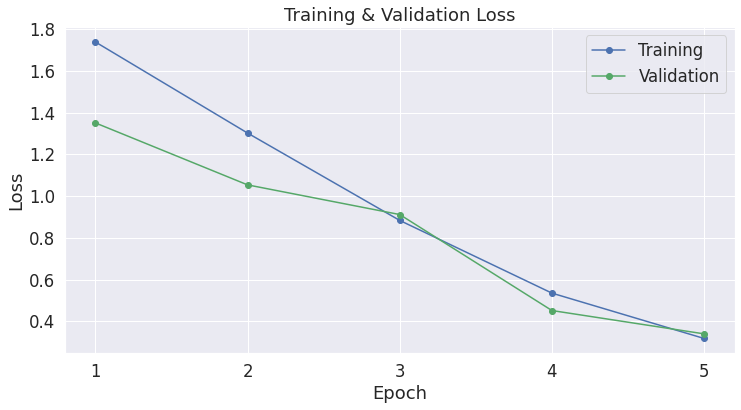

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [ ]:
print("Running Test...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
ep5_model.eval()

# Tracking variables 
total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

y_pred = []
y_true = []

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        outputs = ep5_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        _, prediction = torch.max(logits, dim=1)
        targets = b_labels.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()

        y_pred.extend(prediction)
        y_true.extend(targets.tolist())
        
    # Accumulate the validation loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_test_accuracy += flat_accuracy(logits, label_ids)
    

# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Test Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

Running Test...
  Test Accuracy: 0.89
  Test Loss: 0.40
  Test took: 0:00:56


In [ ]:
print('Precision score: ', precision_score(y_pred, Y_test, average='weighted'))
print('Recall score: ', recall_score(y_pred, Y_test, average='weighted'))
print('F1-score: ', f1_score(y_pred, Y_test, average='weighted'))

Precision score:  0.8994936346838562
Recall score:  0.8903728436282693
F1-score:  0.8933408402386422


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       452
           1       0.97      0.95      0.96       196
           2       0.84      0.86      0.85       141
           3       0.95      0.95      0.95       131
           4       0.88      0.88      0.88       126
           5       0.92      0.95      0.94       110
           6       0.81      0.84      0.82       105
           7       0.91      0.84      0.87        93
           8       0.79      0.91      0.85        89
           9       0.86      0.95      0.91        85
          10       0.78      0.78      0.78        78
          11       0.83      0.79      0.81        56
          12       0.80      0.69      0.74        48
          13       0.57      0.74      0.65        47
          14       0.78      0.32      0.45        22
          15       0.29      0.11      0.16        18

    accuracy                           0.89      1797
   macro avg       0.81   